# Data Anaysis Project part1:


I am currently enrolled in a Google Data Analytics Professional Certificate course and plan to apply the skills and knowledge I am learning to my own data analysis project. This will allow me to solidify my understanding of the concepts and techniques taught in the course. 

#### Process to follow:
* Ask
* Prepare
* Process
* Analyze
* Share
* Act



## Overview of the project:

I am conducting an analysis of the rental housing market in Vancouver to identify popular rental properties in the area. Based on the results, I hope to find a valuable investment property and assess its value. I have chosen to focus on the Vancouver market because it is the one of the most wanted place in Canada, it offers a wide variety of properties, and large pool of potential investments to analyze. 


# ASK 

## Primery question to answer from this analysis:

### "What is the appropriate price to pay for your investment property in current economic condition? And why?"
    
    It's widely believed that Canadian real estate is overpriced, but what is the actual value of a property? To answer this question, I will evaluate property values based on current market conditions and determin the apporopriate price to pay for an investment property. This calculation involves several factors, but I will focus particularly on the revenue generation potential of the property, as this is a crucial aspect of any investment. By analyzing the revenue potential of a property, I aim to gain insight into its true value. 

#### Data source:

    Craigslist advertizement. Data started to collect since December 15, 2022. 

#### Questions to ask.
* Rental price by propety types.
* Rental price by area. 
* Number of advatizing by type of the property.
* Rental price trend.
* Correlation between housing price and rental price. And which way they are trending. 
* What is the short termand long term prediction.  


## Prepare  

### Collect the Data



In [1]:
# Import libralis
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (10, 6), "figure.dpi": 120})
import seaborn as sns

from time import sleep
import re
from random import randint
from warnings import warn
from time import time
from IPython.display import clear_output

In [2]:
class Url:
    def __init__(self, city_name, sub_city=None, num_post=0):
        self.city_name = city_name
        self.sub_city = sub_city
        self.num_post = num_post
        self.url = self.get_url()
        
    def get_url(self):
        if self.city_name == 'Abbotsford':
            url = f'https://{self.city_name.lower()}.craigslist.org/search/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        else:
            url = f'https://{self.city_name.lower()}.craigslist.org/search/{self.sub_city}/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        return url 

In [3]:
# Vanvouver rental housing
url = Url("Vancouver", 'van')
url_ = url.url

response = get(url_)


soup = BeautifulSoup(response.text, 'html.parser')

posts = soup.find_all('li', class_='result-row')
print(type(posts)) # to double check that I got resultSet
print(len(posts)) # to double check I got 120 elements

<class 'bs4.element.ResultSet'>
125


In [4]:
%%time
# Find the total number of posts to find the limit of the pagination
city = 'Vancouver'
sub_city = 'van'
response = get(url_)
soup = BeautifulSoup(response.text, 'html.parser')
posts = soup.find_all('li', class_='result-row')
results_num = soup.find('div', class_='search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)
print(f"Total number of search result: {results_total}")

# each page has 119 posts so each new page is defined as follows; s=120, s=240, .....
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_date = []
post_cities = []
num_bedroom = []
sqfts = []
prices = []
post_titles = []
post_links = []

for page in pages:
    
    # get request
    url = Url(city_name=city, sub_city=sub_city, num_post=page)
    url_ = url.url
    response = get(url_)
    
    sleep(1)
    
    # throw warning for status code that are not 200
    if response.status_code != 200:
        warn(f'Request: {requests}; Status code: {response.status_code}')
        
    soup = BeautifulSoup(response.text, 'html.parser')
    
    posts = soup.find_all('li', class_='result-row')
    
    
    # Extract data 
    for post in posts:
        
        if post.find('span', class_ = 'result-hood') is not None:
            
            # Posting date
            post_datetime = post.find('time', class_='result-date')['datetime']
            post_date.append(post_datetime)
            
            # Neighbourhoods
            post_city = post.find('span', class_='result-hood').text.strip('( )')
            post_cities.append(post_city)
            
            # title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_titles.append(post_title_text)
            
            # Post price in integer
            price = int(post.find('span', class_='result-price').text.split('$')[1].replace(',', ''))
            prices.append(price)
            
            # Post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                num_bedroom.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    num_bedroom.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
        iterations += 1
        #print("Page" + str(iterations) + "Scraped Successfully!")   

Total number of search result: 3000
CPU times: total: 4.39 s
Wall time: 47 s


In [13]:
# create DataFrame
df = pd.DataFrame({'Post Datetime': post_date,
                   'City Code': city.upper()[:3],
                   'Area Code': sub_city.upper(),
                   'Post Title': post_titles,
                   'Post URL': post_links,
                  'Neighborhood': post_cities,
                  'Bedroom': num_bedroom,
                  'SQFT': sqfts,
                  'Price': prices})

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3070 entries, 0 to 3069
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3070 non-null   object 
 1   City Code      3070 non-null   object 
 2   Area Code      3070 non-null   object 
 3   Post Title     3070 non-null   object 
 4   Post URL       3070 non-null   object 
 5   Neighborhood   3070 non-null   object 
 6   Bedroom        2814 non-null   object 
 7   SQFT           2769 non-null   float64
 8   Price          3070 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 216.0+ KB
None


,Post Datetime,City Code,Area Code,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,2022-12-28 20:23,VAN,VAN,Prestigious Harbour Cove - Huge 2 bdrm & 2 bat...,https://vancouver.craigslist.org/van/apa/d/van...,"1450 Pennyfarthing Dr, Vancouver",2,1361.0,3495
1,2022-12-28 20:20,VAN,VAN,"two bedroom + den, 2 bath fully furnished condo",https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1350.0,5580
2,2022-12-28 20:18,VAN,VAN,Ocean View One Bedroom One Bathroom Suite with...,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,1,461.0,3000
3,2022-12-28 20:13,VAN,VAN,new furnished 2 bed 2 bath 1 den Oakridge cond...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,954.0,4600
4,2022-12-28 20:12,VAN,VAN,Vancouver 3 beds laneway house for rent,https://vancouver.craigslist.org/van/apa/d/van...,Victoria & 41st,3,1000.0,3300



## Process

* Clean data
    * Remove duplecates.
    * If the number of bed room is NaN, assume it is bachelor suite (number of bedroom as 0)
    * Convert Post Datetime object to Datetime, then seperate Date and Time. 
    * Sort the dataFrame by Post Datetime. 
    * Convert number of bedroom string to integer. 
* Add parameters to analyze data
    * Specific neighbourhood and clean up messy neighbourhoode. 
    * Post area code connecting the city name and area name to distinguish different area in future with other data. 
    * Calcualte Price/SQFT
    * Find out if the suite is furnished or not by finding the key word "Furnished" in the post title. 
    * Seperate the data by SQFT/Price price range. gategory 1 to 4, which 1 is cheap and 4 is expensive. 
    * I also use unsupervised learning to categorize the dataset. 

### I am trying to identify the area if the address is provided. 

In [14]:
# Get all the Nighborhood start with number, I assume those are address. Then identify the area using google geocoding API.
address = []
for string in df["Neighborhood"].unique():
    if string[0].isdigit():
        address.append(string)
address

['1450 Pennyfarthing Dr, Vancouver',
 '1607, 8189 Cambie Street Vancouver Marpole',
 '376 North Garden Dr',
 '1022 Nelson Street, Vancouver, BC',
 '3003-488 SW Marine Dr., Vancouver, BC, Canada',
 '1239 West Georgia',
 '938 Smithe Street Downtown Vancouver',
 '1308 Hornby St',
 '1199 Seymour Street Vancouver',
 '2070 oak meadows dr. surrey',
 '777 Richards St and Robson St',
 '1200 Alberni Street',
 '1372 Seymour',
 '588 Broughton Street',
 '1644 NELSON ST.',
 '1342 Camridge Road',
 '175 2nd Street West',
 '8625 Osler st, Vancouver',
 '8129 Shaughnessy Street',
 '1323 W. 71st Ave, Vancouver, BC',
 '1680 Bayshore Dr',
 '7418 Paulson Street, Vancouver BC',
 '1057 Barclay Street',
 '455 Abbott Street, Vancouver, BC.',
 '1009 HARWOOD ST',
 '701-928 Beatty Street, Vancouver',
 '438 Seymour St',
 '221 Union St',
 '221 union and Main st',
 '481 W 19th Avenue Vancouver',
 '1788 Columbia Street',
 '1388 Richards Street',
 '1022 Seymour',
 '1022 Seymour Street',
 '1228 W Hastings Street / Downto

If Neighborhood starts with number, then check the area name with google geocoding API. 

if Neighborhood is area name, then use as area name.

clean up all the Neighborhood - cut , / and show same thing but differently. Also, make all lower case. 

In [15]:
# Convert Datetime then split seperate columns
df['Post Datetime'] = pd.to_datetime(df["Post Datetime"])
df['Post Date'] = df['Post Datetime'].dt.date
df['Post Time'] = df['Post Datetime'].dt.time

df["PostAreaCode"] = df["City Code"] + df["Area Code"]

lower_neighbor = []
for area in df["Neighborhood"]:
    neighbor = area.lower()
    lower_neighbor.append(neighbor)
df["Neighborhood"] = lower_neighbor

df = df[["PostAreaCode", 'Post Datetime', 'Post Date', 'Post Time', 'Post Title', 'Post URL', 'Neighborhood', 'Bedroom', 'SQFT', 'Price']]
df.head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,VANVAN,2022-12-28 20:23:00,2022-12-28,20:23:00,Prestigious Harbour Cove - Huge 2 bdrm & 2 bat...,https://vancouver.craigslist.org/van/apa/d/van...,"1450 pennyfarthing dr, vancouver",2,1361.0,3495
1,VANVAN,2022-12-28 20:20:00,2022-12-28,20:20:00,"two bedroom + den, 2 bath fully furnished condo",https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1350.0,5580
2,VANVAN,2022-12-28 20:18:00,2022-12-28,20:18:00,Ocean View One Bedroom One Bathroom Suite with...,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,1,461.0,3000
3,VANVAN,2022-12-28 20:13:00,2022-12-28,20:13:00,new furnished 2 bed 2 bath 1 den Oakridge cond...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,954.0,4600
4,VANVAN,2022-12-28 20:12:00,2022-12-28,20:12:00,Vancouver 3 beds laneway house for rent,https://vancouver.craigslist.org/van/apa/d/van...,victoria & 41st,3,1000.0,3300


In [16]:
# Convert Bedroom number strings to Integer then NaN value to 0 assume 0 bedroom is studio appartment. 
df["Bedroom"] = pd.to_numeric(df["Bedroom"], errors='ignore').astype('Int64')
df["Bedroom"] = df["Bedroom"].fillna(0)

In [17]:
%%time
# Check if word 'furnished' in the title post. 
search_word = 'furnished'
furnished = []
for i in range(len(df)):
    post_title_list = df['Post Title'][i].lower().split(" ")
    if any(word == search_word for word in post_title_list):
        furnished.append(True)
    else:
        furnished.append(False)
df["IsFurnished"] = furnished

CPU times: total: 0 ns
Wall time: 13.1 ms


#### Clean up the neighborhood. 

In [18]:
# After split neighborhood to list, back to one string
def back_to_string(word_list):
    neighbour = ''
    
    for word in word_list:
        neighbour += (word + ' ')
    return neighbour

neighourhood = []
for i in range(len(df)):
    neighbor_word_list = df["Neighborhood"][i].replace(',', ' ').replace('/', ' ').split(" ")
    if 'yaletown' in neighbor_word_list:
        neighbor = 'yaletown'
    elif 'downtown' in neighbor_word_list:
        neighbor = 'downtown'
    elif 'dt' in neighbor_word_list:
        neighbor = 'downtown'
    elif "west" in neighbor_word_list and 'vancouver' in neighbor_word_list:
        neighbor = 'west vancouver'
    elif 'city' in neighbor_word_list and 'vancouver' in neighbor_word_list:
        neighbor = 'vancouver'
    elif 'west' in neighbor_word_list and 'west' in neighbor_word_list:
        neighbor = 'west end'
    elif len(neighbor_word_list) > 4:
        neighbor = 'vancouver'
    else:
        neighbor = back_to_string(neighbor_word_list)
    neighourhood.append(neighbor)
df['Neighborhood'] = neighourhood

Get the per SQFT price. Then categorize the dataframe by price.

In [19]:
# Calculate Price/SQFT
df["Price/SQFT"] = df["Price"] / df["SQFT"]
df['Price/SQFT'].fillna(0, inplace=True)
df["SQFT"] = df["SQFT"].fillna(0)
p_per_sqft_df = df[["Neighborhood", "Bedroom", "Price", "Price/SQFT"]].sort_values(by="Price/SQFT", ascending=False)

In [20]:
df['Price/SQFT'].describe()

count    3070.000000
mean        4.696355
std        31.493846
min         0.000000
25%         3.065395
50%         4.142857
75%         5.055556
max      1650.000000
Name: Price/SQFT, dtype: float64

In [21]:
df['price_range'] = pd.cut(df['Price/SQFT'], bins=[-1, 0.5, 3.4, 4.2, 5.8, 13], labels=[0, 1, 2, 3, 4], include_lowest=False)

In [22]:
# Sort DataFrame by Datetime
df.sort_values(by="Post Datetime", axis=0, ascending=False, inplace=True)

In [23]:
# Remove duplicates by post title
df.drop_duplicates(subset="Post Title", inplace=True)
df = df.reset_index(drop=True)
len(df)

2615

## Understanding the Data

Use visualization to understand the data. 



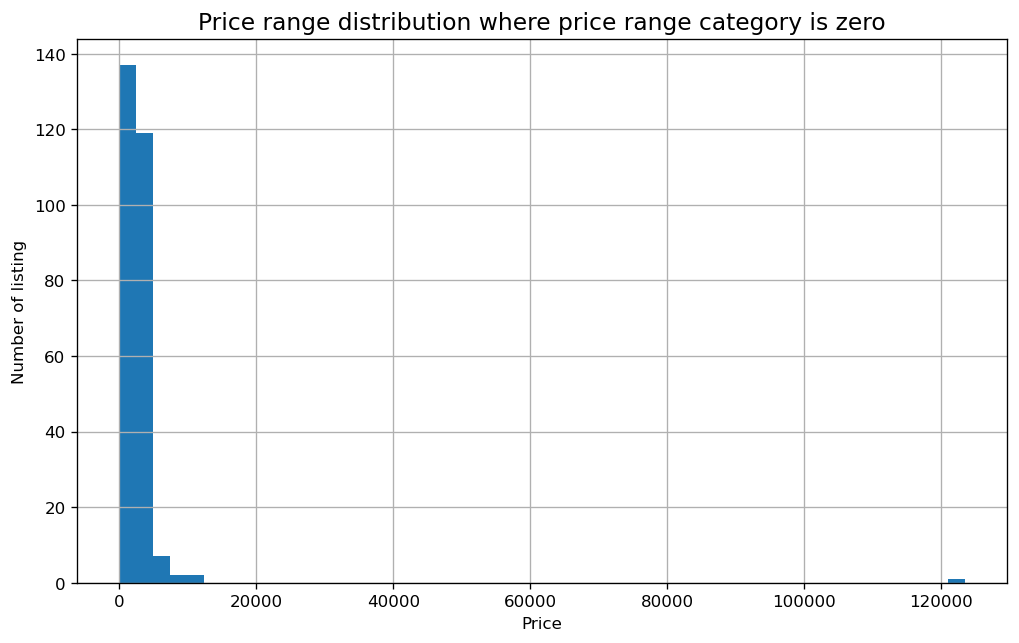

In [18]:
df[df['price_range'] == 0]['Price'].hist(bins=50)
plt.title('Price range distribution where price range category is zero', fontsize=14)
plt.xlabel("Price")
plt.ylabel('Number of listing');

In [19]:
# First, show the highest price of the ads. 
df.sort_values(by='Price', ascending=False).head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
1124,VANVAN,2022-12-23 15:22:00,2022-12-23,15:22:00,"Bachelor, 1 and 2 Bedroom Apartments",https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,NaN,123456,False,0.000000,0
2134,VANVAN,2022-12-12 10:56:00,2022-12-12,10:56:00,Ultra Customized Morden Luxury House In West P...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,4,3958.0,25000,False,6.316321,4
1533,VANVAN,2022-12-20 11:11:00,2022-12-20,11:11:00,Furnished Two Bedroom Sub-Penthouse at Shangri...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,2694.0,25000,True,9.279881,4
901,VANVAN,2022-12-26 10:06:00,2022-12-26,10:06:00,Luxury Furnished 3 Bed + Den 4 Bath Condo at T...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2223.0,24995,True,11.243815,4
196,VANVAN,2022-12-27 22:03:00,2022-12-27,22:03:00,Furnished luxury Mansion 7 bed/7 bath availabl...,https://vancouver.craigslist.org/van/apa/d/wes...,west vancouver,6,10000.0,22880,True,2.288000,1


In [20]:
#I found outlier so I drop it to start. 
df.drop(df[df["Price"] == 500000].index, axis=0, inplace=True)

## Price distribution

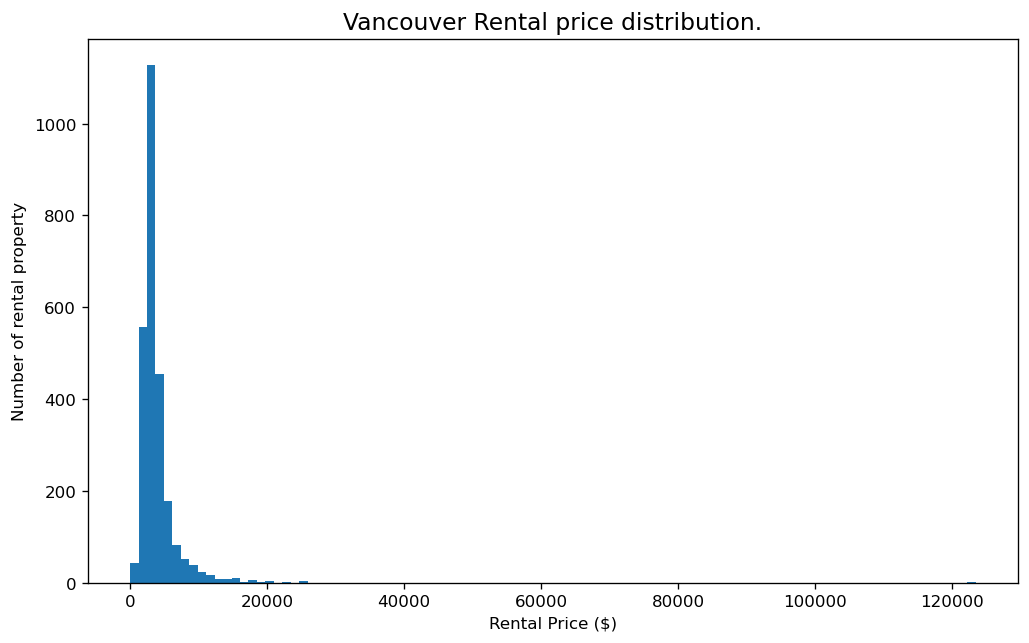

In [21]:
plt.hist(df["Price"], bins=100)
plt.title(f'{city} Rental price distribution.', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

## Relationship between Price and SQFT

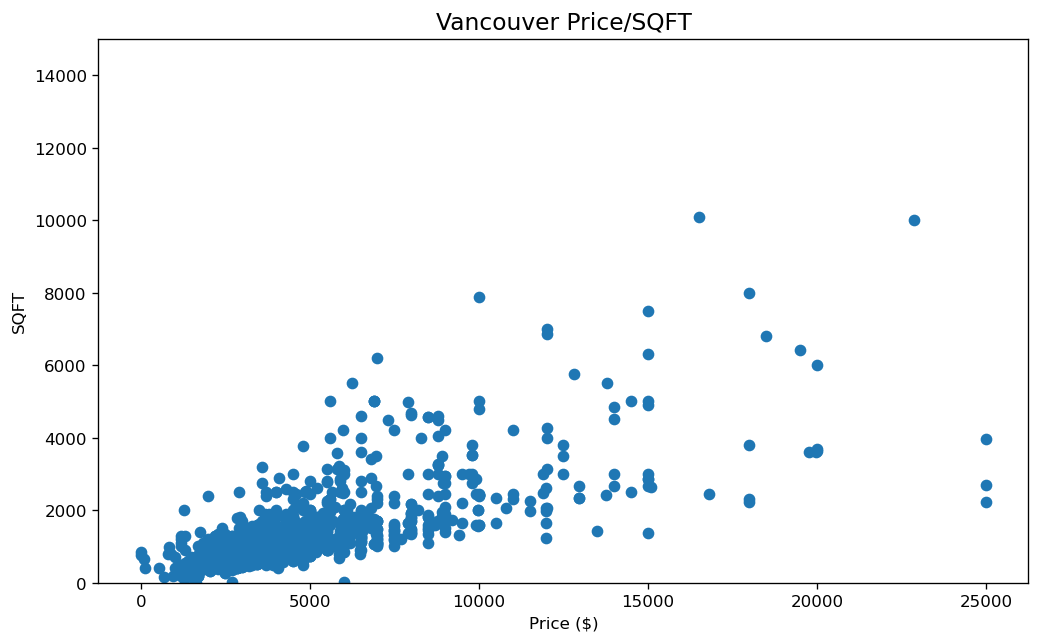

In [22]:
# Relationship between SQFT and Price
plt.scatter(x=df["Price"], y=df["SQFT"])
plt.ylim((0, 15000))
plt.title(f"{city} Price/SQFT", fontsize=14)
plt.xlabel(f"Price ($)")
plt.ylabel(f"SQFT");

In [23]:
# Drop rows if sqft is zero
p_per_sqft_df.fillna(0, inplace=True)
no_sqft_idx = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] == 0].index
p_per_sqft_df.drop(no_sqft_idx, axis=0, inplace=True)

In [24]:
# Drop rows if Price/SQFT > $20
p_per_sqft_df = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] < 20]

## Distribution of Per SQFT Price

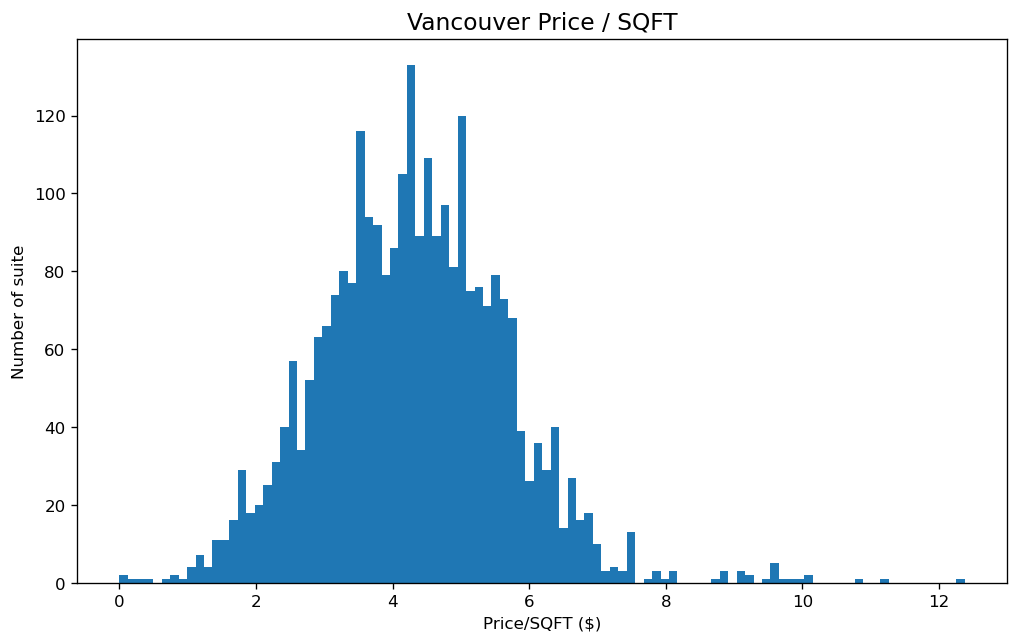

In [25]:
plt.hist(p_per_sqft_df["Price/SQFT"], bins=100)
plt.title(f"{city} Price / SQFT", fontsize=14)
plt.xlabel("Price/SQFT ($)")
plt.ylabel("Number of suite");

0
count    268.000000
mean       0.003143
std        0.031209
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.386049
Name: Price/SQFT, dtype: float64

1
count    601.000000
mean       2.636254
std        0.584280
min        0.640000
25%        2.297297
50%        2.774632
75%        3.122649
max        3.400000
Name: Price/SQFT, dtype: float64

2
count    556.000000
mean       3.794596
std        0.236864
min        3.404255
25%        3.583333
50%        3.795058
75%        4.000000
max        4.200000
Name: Price/SQFT, dtype: float64

3
count    958.000000
mean       4.897352
std        0.453915
min        4.200323
25%        4.512360
50%        4.851948
75%        5.281162
max        5.800000
Name: Price/SQFT, dtype: float64

4
count    228.000000
mean       6.670643
std        1.043903
min        5.802220
25%        6.051627
50%        6.331301
75%        6.805548
max       12.378641
Name: Price/SQFT, dtype: float64



2611

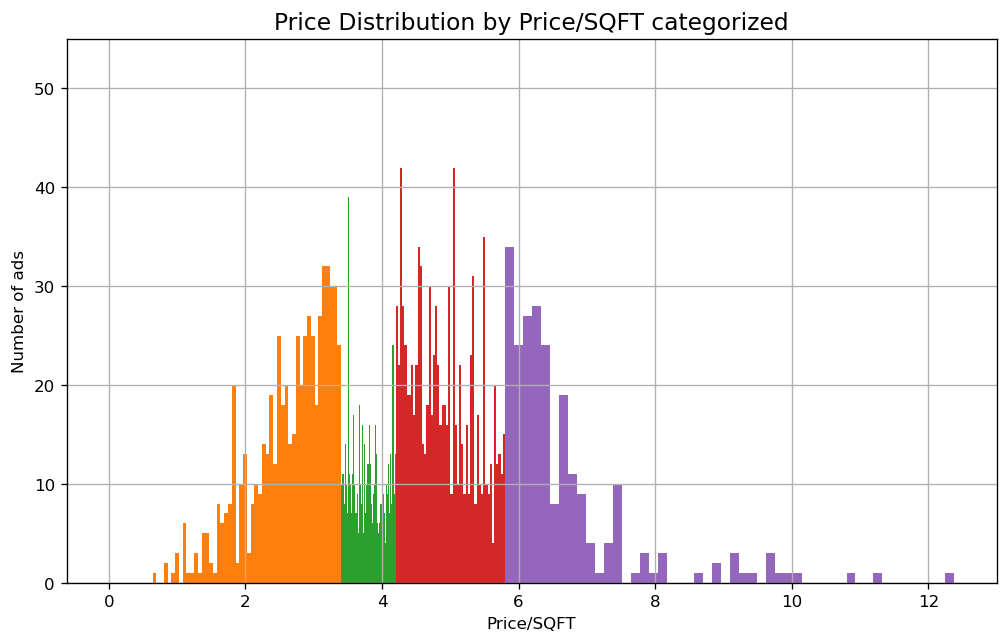

In [26]:
df_grouped = df.groupby('price_range')

number_row = 0
# Print data frame, lenth of data by category
for name, group in df_grouped:
    print(name)
    group['Price/SQFT'].hist(bins=50)
    plt.ylim(0, 55)
    plt.title("Price Distribution by Price/SQFT categorized", fontsize=14)
    plt.xlabel('Price/SQFT')
    plt.ylabel('Number of ads')
    print(group["Price/SQFT"].describe())
    number_row += len(group)
    print()
number_row

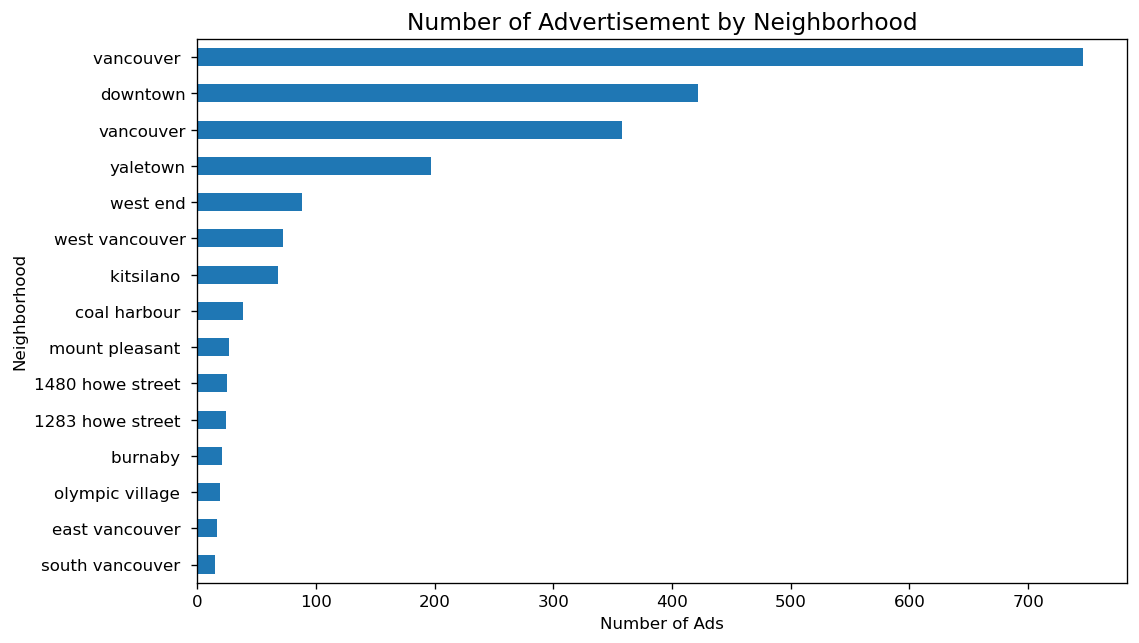

In [27]:
top_15_ads_count_by_area = p_per_sqft_df["Neighborhood"].value_counts().head(15).sort_values(ascending=True)
top_15_ads_count_by_area.plot(kind='barh')
plt.title('Number of Advertisement by Neighborhood', fontsize=14)
plt.xlabel('Number of Ads')
plt.ylabel("Neighborhood");

In [28]:
# Drop all of the neighborhood is 1. 
p_per_neighbor = p_per_sqft_df.groupby(by="Neighborhood").agg({"Price/SQFT": ['count', 'mean', 'min', 'max']})
p_per_neighbor['Price/SQFT'].sort_values(by='count', ascending=False).head(15)

,count,mean,min,max
Neighborhood,,,,
vancouver,746,4.269604,0.001176,12.378641
downtown,422,5.108980,0.001325,10.877447
vancouver,358,4.090864,1.413793,6.794218
yaletown,197,4.977239,1.842308,8.097166
west end,88,4.647928,1.120000,9.420796
west vancouver,72,3.467696,1.000000,10.000000
kitsilano,68,3.899487,1.090909,6.211111
coal harbour,39,4.421393,2.843750,6.925743
mount pleasant,27,4.402722,2.227273,5.808758


## Number of ads on each bedroom

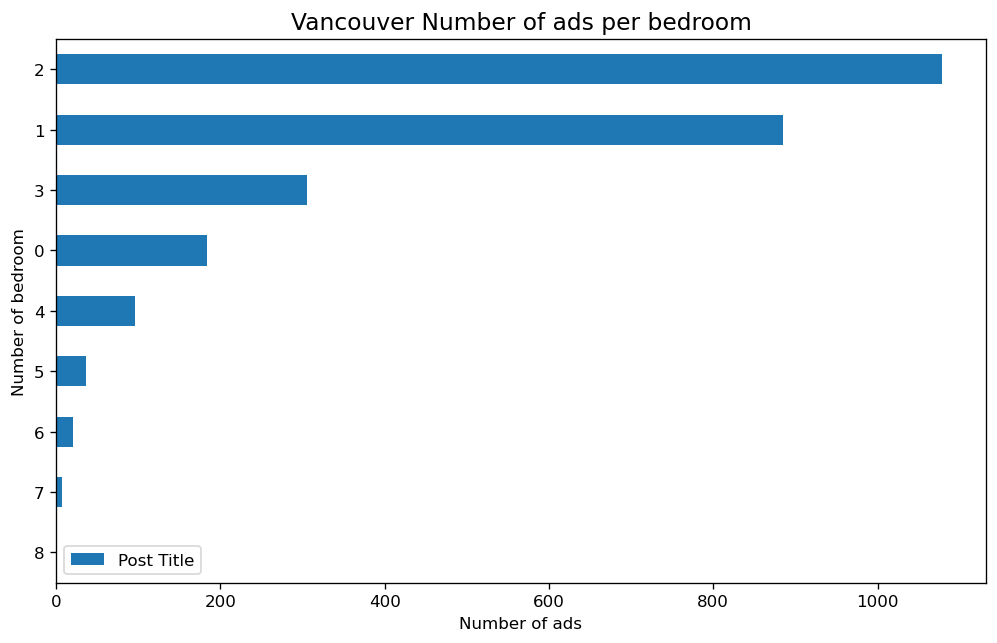

In [29]:
num_bed = df.groupby('Bedroom').agg({'Post Title': 'count'}).sort_values(by='Post Title', ascending=True)
num_bed.plot(kind='barh')
plt.title(f"{city} Number of ads per bedroom", fontsize=14)
plt.xlabel("Number of ads")
plt.ylabel("Number of bedroom");

In [30]:
# Percentage of the number of listing. 
num_bed["percent"] = num_bed / len(df) * 100
num_bed.rename(columns={'Post Title': "Number of Ads", 'percent': 'Percentage'}, inplace=True)

In [31]:
num_bed

,Number of Ads,Percentage
Bedroom,,
8,1,0.038256
7,7,0.267789
6,21,0.803366
5,37,1.415455
4,96,3.672533
0,184,7.039021
3,305,11.667942
1,885,33.856159
2,1078,41.239480


In [32]:
# Price less than $300
df[df['Price'] < 300]

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
151,VANVAN,2022-12-28 08:28:00,2022-12-28,08:28:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/van...,1644 nelson st.,0,NaN,0,False,0.000000,0
394,VANVAN,2022-12-27 11:48:00,2022-12-27,11:48:00,Quay Pacific,https://vancouver.craigslist.org/van/apa/d/abb...,vancouver and lower mainland,3,NaN,0,False,0.000000,0
426,VANVAN,2022-12-27 10:35:00,2022-12-27,10:35:00,WANTED - Shared apt in downtown Vancouver,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,850.0,1,False,0.001176,0
475,VANVAN,2022-12-27 09:43:00,2022-12-27,09:43:00,Pretty studio suite for housekeeping,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,NaN,1,False,0.000000,0
930,VANVAN,2022-12-26 06:19:00,2022-12-26,06:19:00,scam! beware 1 bdrm in freesia building downto...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,1,755.0,1,False,0.001325,0
1733,VANVAN,2022-12-17 15:59:00,2022-12-17,15:59:00,Need help with housing,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,1,False,0.000000,0
1765,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,0.000000,0
2033,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,0,False,0.000000,0
2119,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,400.0,120,True,0.300000,0
2319,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,0.000000,0


This post is daily rental. From this, I assume teh rental price around $100 would be daily rental suite. 

What about $1 or $0 posts?

In [33]:
# $1 ads
one_dollar = df[df["Price"] == 1]
one_dollar["Post URL"]

426     https://vancouver.craigslist.org/van/apa/d/van...
475     https://vancouver.craigslist.org/van/apa/d/van...
930     https://vancouver.craigslist.org/van/apa/d/van...
1733    https://vancouver.craigslist.org/van/apa/d/van...
Name: Post URL, dtype: object

In [34]:
# $0 ads
zero_dollar = df[df["Price"] == 0]
zero_dollar

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
151,VANVAN,2022-12-28 08:28:00,2022-12-28,08:28:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/van...,1644 nelson st.,0,NaN,0,False,0.0,0
394,VANVAN,2022-12-27 11:48:00,2022-12-27,11:48:00,Quay Pacific,https://vancouver.craigslist.org/van/apa/d/abb...,vancouver and lower mainland,3,NaN,0,False,0.0,0
2033,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,0,False,0.0,0
2319,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,0.0,0
2454,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,0,False,0.0,0


I think it most likely 0 dollar and 1 dollar ads are just not showing the price, so I will drop those rows from DataFrame. 

In [35]:
# Drop low-end outliers rows
drop_index = []
for idx in one_dollar.index:
    drop_index.append(idx)
for idx in zero_dollar.index:
    drop_index.append(idx)
print(f"Original DataFrame Size:{len(df)}\nNumber of Dropped Rows: {len(drop_index)}")
df.drop(drop_index,axis=0, inplace=True)
print(f"DataFrame size after drop rows: {len(df)}")

Original DataFrame Size:2614
Number of Dropped Rows: 9
DataFrame size after drop rows: 2605


## Analyze - 1

From the Histgram, the highest amount of rental is between 1000 to 5000. First I look what kind of market above 5000. 

I call this as 

## High-End market research


In [36]:
# top 100 higest price 
top_100_price = df[['Post Datetime', 'Neighborhood', 'Bedroom', 'SQFT', 'Price', 'IsFurnished']].sort_values(
                by="Price", ascending=False).head(100)
top_100_price.head(30)


,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1124,2022-12-23 15:22:00,vancouver,2,NaN,123456,False
1533,2022-12-20 11:11:00,vancouver,2,2694.0,25000,True
2134,2022-12-12 10:56:00,vancouver,4,3958.0,25000,False
901,2022-12-26 10:06:00,vancouver,3,2223.0,24995,True
196,2022-12-27 22:03:00,west vancouver,6,10000.0,22880,True
1041,2022-12-25 10:18:00,vancouver,3,3636.0,20000,False
1234,2022-12-22 15:46:00,dowtown,4,3700.0,19998,False
489,2022-12-27 09:25:00,west vancouver,7,6000.0,19995,True
472,2022-12-27 09:45:00,west vancouver,3,3600.0,19975,False
1235,2022-12-22 15:46:00,west vancouver,3,3600.0,19750,False


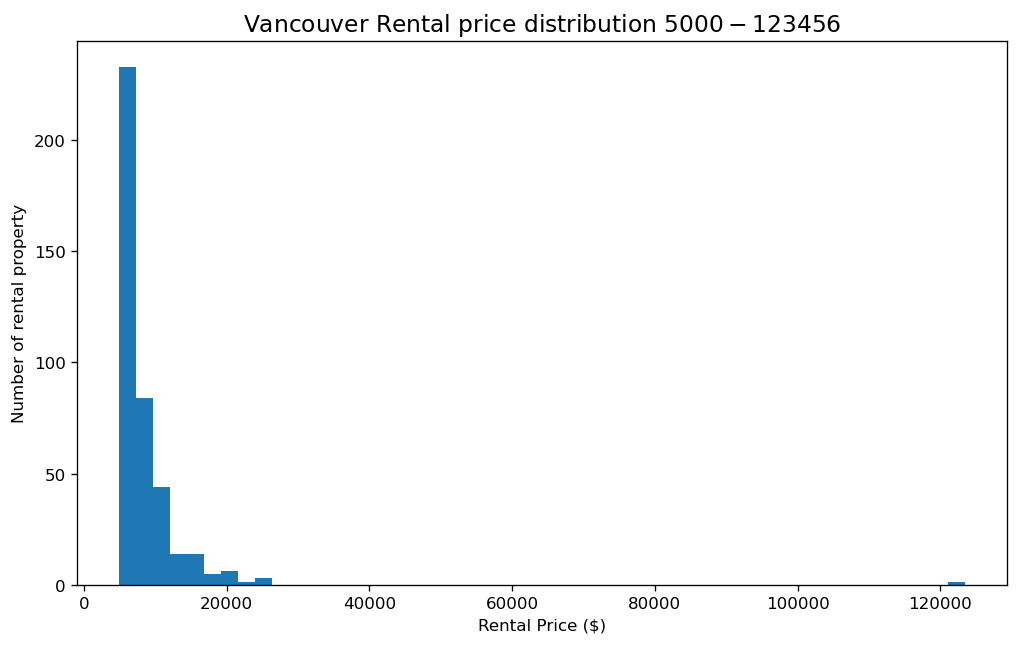

In [37]:
# What about distribution $5000 and up?
price_range = (5000, df["Price"].max())
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [38]:
# Get URL on 2 Bedroom suite in top 100. 
highest_two_bed = top_100_price[top_100_price['Bedroom'] == 2]
highest_two_bed_idx = highest_two_bed.index
for idx in highest_two_bed_idx:
    print(f'Index Number - {idx} : {df.loc[idx]["Post URL"]}')


Index Number - 1124 : https://vancouver.craigslist.org/van/apa/d/vancouver-bachelor-and-bedroom/7571409378.html
Index Number - 1533 : https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7560020204.html
Index Number - 2353 : https://vancouver.craigslist.org/van/apa/d/vancouver-vancouver-downtown-fairmont/7554964282.html
Index Number - 199 : https://vancouver.craigslist.org/van/apa/d/vancouver-fairmont-loft-bedroom/7571765246.html
Index Number - 65 : https://vancouver.craigslist.org/van/apa/d/vancouver-uniqueaccommodationscom/7567894912.html
Index Number - 55 : https://vancouver.craigslist.org/van/apa/d/vancouver-breathtaking-views-2500-sq-ft/7570816160.html
Index Number - 1485 : https://vancouver.craigslist.org/van/apa/d/vancouver-super-luxury-07-fairmont-bed/7565383014.html
Index Number - 1251 : https://vancouver.craigslist.org/van/apa/d/vancouver-luxurious-private-estates-of/7571084372.html
Index Number - 1269 : https://vancouver.craigslist.org/van/apa/d/van

#### What is 0.85% RULE?

This is the rough calculation to find out the purchase price to give 5 - 8% cash flow from your rental revenue with today's motgagerate. It's not accurate number but great place to start evaluating the home price for your investment. 

In [39]:
# Average Price on those pent house
avg_rent = np.average(highest_two_bed["Price"][1:].to_numpy())
max_rent = np.max(highest_two_bed["Price"][1:].to_numpy())
# 0.85% RULE
avg_house_p = np.round(avg_rent / (0.85/100), 2)
max_house_p = np.round(max_rent / (0.85/100), 2)
print(f"Price between ${avg_house_p*0.8} - ${max_house_p}")

Price between $1161069.52 - $2941176.47


In [40]:
# Rental price higher than $5000.
more_than_5000 = df[df["Price"] > 5000]
more_than_5000.groupby(by=["Bedroom", "IsFurnished"]).agg({'SQFT': ["min", "max"],
                                                         "Price": ['min', 'max', 'count']})

SQFT           Price              
                        min      max    min     max count
Bedroom IsFurnished                                      
0       True         1357.0   1357.0   8000    8000     1
1       False        2000.0   2000.0   6500    6500     1
        True          900.0   1855.0   5500    8500     3
2       False         675.0   2936.0   5190  123456    87
        True          800.0   2873.0   5100   25000    66
3       False          14.0   4000.0   5100   20000    78
        True         1000.0   4000.0   5200   24995    36
4       False        1312.0   6300.0   5200   25000    37
        True         1400.0   6800.0   5500   18500    18
5       False        1500.0   6850.0   5200   19500    24
        True         2500.0   4913.0   6500   14995     7
6       False        2300.0  10098.0   5600   18000    13
        True         3000.0  29789.0   5600   22880     6
7       False        2900.0   4800.0   6500    9995     5
        True         6000.0   6000.0  19995   19995     1
8       False        4980.0   4980.0   7900    7900     1

In [41]:
# top 10 most expensive rental in Vancouver
top_10 = top_100_price.head(10)
top_10

,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1124,2022-12-23 15:22:00,vancouver,2,NaN,123456,False
1533,2022-12-20 11:11:00,vancouver,2,2694.0,25000,True
2134,2022-12-12 10:56:00,vancouver,4,3958.0,25000,False
901,2022-12-26 10:06:00,vancouver,3,2223.0,24995,True
196,2022-12-27 22:03:00,west vancouver,6,10000.0,22880,True
1041,2022-12-25 10:18:00,vancouver,3,3636.0,20000,False
1234,2022-12-22 15:46:00,dowtown,4,3700.0,19998,False
489,2022-12-27 09:25:00,west vancouver,7,6000.0,19995,True
472,2022-12-27 09:45:00,west vancouver,3,3600.0,19975,False
1235,2022-12-22 15:46:00,west vancouver,3,3600.0,19750,False


In [42]:
# Then get the URL on those top 10 most expensive rental in Vancouver. 
top_10_idx = top_10.index
for idx in top_10_idx:
    print(f'Index Number - {idx}/Number of Bedroom - {df.loc[idx]["Bedroom"]}/SQFT - {df.loc[idx]["SQFT"]}/Location - {df.loc[idx]["Neighborhood"]}\n{df.loc[idx]["Post URL"]}')

Index Number - 1124/Number of Bedroom - 2/SQFT - nan/Location - vancouver 
https://vancouver.craigslist.org/van/apa/d/vancouver-bachelor-and-bedroom/7571409378.html
Index Number - 1533/Number of Bedroom - 2/SQFT - 2694.0/Location - vancouver 
https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7560020204.html
Index Number - 2134/Number of Bedroom - 4/SQFT - 3958.0/Location - vancouver 
https://vancouver.craigslist.org/van/apa/d/vancouver-ultra-customized-morden/7567534610.html
Index Number - 901/Number of Bedroom - 3/SQFT - 2223.0/Location - vancouver 
https://vancouver.craigslist.org/van/apa/d/vancouver-luxury-furnished-bed-den-bath/7568077632.html
Index Number - 196/Number of Bedroom - 6/SQFT - 10000.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/west-vancouver-furnished-luxury-mansion/7562366149.html
Index Number - 1041/Number of Bedroom - 3/SQFT - 3636.0/Location - vancouver 
https://vancouver.craigslist.org/van/apa/d/vancouver-coa

From above data, Downtown Vanvouver rental market is different world. I must make decision to define what is the outlier of high-end rental. 

If the number of the high-end prices are large enough, I can make DataFrame for only high-end and search for the high-end market opportunities. 

Clearly, I should not mix with regular market and high-end market because it will provide me biased price average to determin the valuse of the house. 

I am wondering that <a href='https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/Table?TableId=2.1.31.3&GeographyId=2410&GeographyTypeId=3&DisplayAs=Table&GeograghyName=Vancouver'>CMHC Vancouver rental market report</a> concerns about those outliers. 

## Analyze - 2 


## Analyze under 5000, and i call them for regular market. 
* What is the percentage of the Furnished rental suite? 
* Is there any price different? 
* How many bedroom suite has most on ads? And is it any different in area?
* How much is the rental price in general? 


Tne price around $100 is most likely daily rental so I will store in different variable so I might be able to do something with them. 

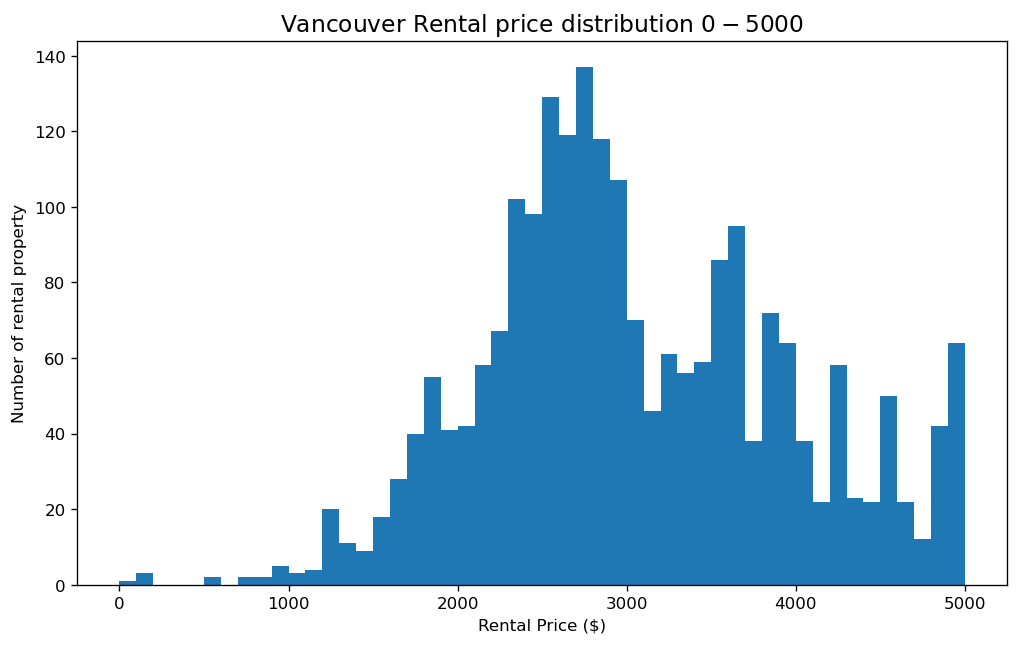

In [43]:
# What about distribution $0 - $5000?
price_range = (0, 5000)
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [44]:
day_rental = df[df["Price"].between(10, 300)]
day_rental

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
1765,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,0.000000,0
2119,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,400.0,120,True,0.300000,0
2396,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,90,False,0.000000,0
2583,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,650.0,100,True,0.153846,0


In [45]:
# Drop the rental price over $5000. 
under_5000 = df.drop(more_than_5000.index, axis=0)
print(f'Drop {len(more_than_5000)} rows and data contains {len(under_5000)} rows of data.')

Drop 384 rows and data contains 2221 rows of data.


In [46]:
# then also drop daily rentals
under_5000 = under_5000.drop(day_rental.index, axis=0)
print(f'Drop {len(day_rental)} rows and data contains {len(under_5000)} rows of data.')

Drop 4 rows and data contains 2217 rows of data.


In [47]:
# What is the top 10 highest price on under $5000. Is it no outlier?
under_5000.sort_values(by="Price", ascending=False).head(10)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
1777,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Furnished Short term Apartment at Avenue O...,https://vancouver.craigslist.org/van/apa/d/van...,olympic village,2,1000.0,5000,True,5.000000,3
1786,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Pet friendly Apartment at Cambie Gardens 7...,https://vancouver.craigslist.org/van/apa/d/van...,oakridge,2,1155.0,5000,False,4.329004,3
2282,VANVAN,2022-12-09 09:35:00,2022-12-09,09:35:00,Arthur Erickson Waterfall Building 1 Bed + Den...,https://vancouver.craigslist.org/van/apa/d/van...,armory district,1,1000.0,5000,False,5.000000,3
1465,VANVAN,2022-12-20 15:48:00,2022-12-20,15:48:00,2 BED + DEN W/ VIEWS FOR RENT @ CIELO!!,https://vancouver.craigslist.org/van/apa/d/van...,coal harbour,2,1277.0,5000,False,3.915427,2
289,VANVAN,2022-12-27 16:52:00,2022-12-27,16:52:00,"Eco Penthouse Loft, with Private Roof Deck",https://vancouver.craigslist.org/van/apa/d/van...,west end,2,900.0,5000,False,5.555556,3
1993,VANVAN,2022-12-13 20:38:00,2022-12-13,20:38:00,"Fully Renovated, Entire House, Available for Rent",https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2000.0,5000,False,2.500000,1
2163,VANVAN,2022-12-11 21:20:00,2022-12-11,21:20:00,NEW BUILDING-Available February 1st -Pet Frien...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,3,745.0,5000,False,6.711409,4
229,VANVAN,2022-12-27 19:59:00,2022-12-27,19:59:00,5 star luxury Shangri-La hotel condo(furnished...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1045.0,5000,False,4.784689,3
849,VANVAN,2022-12-26 11:07:00,2022-12-26,11:07:00,Spacious 3BED/2BATH @ 8X On the Park,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,3,1200.0,5000,False,4.166667,2
983,VANVAN,2022-12-25 20:00:00,2022-12-25,20:00:00,FRASER AND 41ST VANCOUVER EAST HOUSE 3 BED 2 BATH,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2000.0,5000,False,2.500000,1


In [48]:
# How many rentals are $5000?
under_5000[under_5000["Price"] == 5000] 

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
78,VANVAN,2022-12-28 09:48:00,2022-12-28,09:48:00,(UniqueAccommodations.com) ID:4949 4 BED rare ...,https://vancouver.craigslist.org/van/apa/d/van...,cambie,4,1839.0,5000,False,2.718869,1
79,VANVAN,2022-12-28 09:47:00,2022-12-28,09:47:00,(UniqueAccommodations.com) ID:5184 Kitsilano 2...,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,2,1100.0,5000,False,4.545455,3
162,VANVAN,2022-12-28 07:36:00,2022-12-28,07:36:00,Luxury modern new furnished Vancouver Suite,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,950.0,5000,True,5.263158,3
229,VANVAN,2022-12-27 19:59:00,2022-12-27,19:59:00,5 star luxury Shangri-La hotel condo(furnished...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1045.0,5000,False,4.784689,3
289,VANVAN,2022-12-27 16:52:00,2022-12-27,16:52:00,"Eco Penthouse Loft, with Private Roof Deck",https://vancouver.craigslist.org/van/apa/d/van...,west end,2,900.0,5000,False,5.555556,3
849,VANVAN,2022-12-26 11:07:00,2022-12-26,11:07:00,Spacious 3BED/2BATH @ 8X On the Park,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,3,1200.0,5000,False,4.166667,2
983,VANVAN,2022-12-25 20:00:00,2022-12-25,20:00:00,FRASER AND 41ST VANCOUVER EAST HOUSE 3 BED 2 BATH,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2000.0,5000,False,2.500000,1
1274,VANVAN,2022-12-22 11:32:00,2022-12-22,11:32:00,Spacious 3 Bedroom + Den Available for Lease,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,1200.0,5000,False,4.166667,2
1465,VANVAN,2022-12-20 15:48:00,2022-12-20,15:48:00,2 BED + DEN W/ VIEWS FOR RENT @ CIELO!!,https://vancouver.craigslist.org/van/apa/d/van...,coal harbour,2,1277.0,5000,False,3.915427,2
1609,VANVAN,2022-12-19 14:14:00,2022-12-19,14:14:00,"--(OBsold.com)-- Stunning Furnished 1bd+den, m...",https://vancouver.craigslist.org/van/apa/d/nor...,lower lonsdale,1,733.0,5000,True,6.821282,4


In [49]:
# What is the cheapest rent?
under_5000.sort_values(by="Price").head(20)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
2158,VANVAN,2022-12-11 21:39:00,2022-12-11,21:39:00,Double Car Garage for rent !!,https://vancouver.craigslist.org/van/apa/d/van...,vancouver east fraserview area,0,400.0,550,False,1.375000,1
1706,VANVAN,2022-12-18 12:44:00,2022-12-18,12:44:00,Rooms in SRO building from $595,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,595,False,0.000000,0
1515,VANVAN,2022-12-20 12:44:00,2022-12-20,12:44:00,Nice and cozy room available (H65) (Surrey),https://vancouver.craigslist.org/van/apa/d/sur...,surrey,1,NaN,700,False,0.000000,0
735,VANVAN,2022-12-26 17:30:00,2022-12-26,17:30:00,Microsuite Available Now,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,150.0,700,False,4.666667,3
194,VANVAN,2022-12-27 22:09:00,2022-12-27,22:09:00,"CONVENIENT, FURNISHED BASEMENT SUITE AVAILABLE...",https://vancouver.craigslist.org/van/apa/d/van...,east vancouver,3,800.0,800,True,1.000000,1
1332,VANVAN,2022-12-21 19:40:00,2022-12-21,19:40:00,Room for rent $830/month! utilities & internet...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,997.0,830,False,0.832497,1
1823,VANVAN,2022-12-16 11:50:00,2022-12-16,11:50:00,student accommodation,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,800.0,900,False,1.125000,1
1162,VANVAN,2022-12-23 08:39:00,2022-12-23,08:39:00,One in Kits on West Broadway 10 mins from UBC...,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano vancouver,6,NaN,950,False,0.000000,0
654,VANVAN,2022-12-26 22:06:00,2022-12-26,22:06:00,Room for rent only January,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,4,NaN,950,False,0.000000,0
1261,VANVAN,2022-12-22 13:14:00,2022-12-22,13:14:00,Micro-Mini suite(Ground Level 5th and Nanaimo/...,https://vancouver.craigslist.org/van/apa/d/mic...,vancouver east,0,191.0,950,False,4.973822,3


In [50]:
# Count how many rentals are furnished 
num_furnished_suite = df[df['IsFurnished'] == True]["IsFurnished"].count()
num_unfurnished_suite = len(df) - num_furnished_suite
furnished_suite_percent = np.round((num_furnished_suite / len(df)) * 100, 2)
print(f"Number of furnished suite is {num_furnished_suite}, and it's {furnished_suite_percent}% of the entire list.")

Number of furnished suite is 672, and it's 25.8% of the entire list.


In [51]:
# Find out the number of ads on each bedrooms number.  
num_bed = np.sort(df["Bedroom"].unique())
suite_counts = []
for i in range(len(num_bed)):
    suite_count = len(df[df['Bedroom'] == num_bed[i]])
    suite_counts.append(suite_count)
    #print(f'Number of {num_bed[i]} Bedroom suite: {len(df[df["Bedroom"] == num_bed[i]])}')
#print(f"List of suite counts: {suite_counts}")

In [52]:
# Find out Mean, Max, Min of SQFT and Price of each bedroom and SUM of furnished suite and total suite on each bedroom. 
df_count = df.groupby(by=['Bedroom']).agg({'SQFT': ['mean', 'max', 'min'],
                                                 'Price': ['mean', 'max', 'min'],
                                                  'IsFurnished': ['sum', 'count']})
df_count['percent furnished'] = df_count['IsFurnished']['sum'] / df_count["IsFurnished"]['count']
df_count

SQFT                         Price               IsFurnished  \
                mean      max     min         mean     max   min         sum   
Bedroom                                                                        
0         431.944785   1357.0   103.0  2333.823204    8000   550          60   
1         615.763057   2400.0     1.0  2581.048808    8500    90         266   
2         984.366530   2936.0     7.0  4074.554318  123456   990         247   
3        1531.342857   4000.0    14.0  5558.500000   24995   800          65   
4        2579.697674   6800.0   900.0  6730.083333   25000   950          20   
5        3884.971429   6850.0  1500.0  8785.648649   19500  1300           7   
6        6656.000000  29789.0  2300.0  9753.571429   22880   950           6   
7        4028.333333   6000.0  1300.0  8798.571429   19995  1300           1   
8        4980.000000   4980.0  4980.0  7900.000000    7900  7900           0   

              percent furnished  
        count                    
Bedroom                          
0         181          0.331492  
1         881          0.301930  
2        1077          0.229341  
3         304          0.213816  
4          96          0.208333  
5          37          0.189189  
6          21          0.285714  
7           7          0.142857  
8           1          0.000000

In [53]:
# Price per furnished suit on each bedroom
#df_price_furnished = df.drop(['Post Datetime', 'Post Title', 'Post URL', 'Neighborhood'], axis=1)
df_price_furnished = df.groupby(['Bedroom', 'IsFurnished']).agg({'Price': ['mean', 'max', 'min', 'count'],
                                                               "SQFT": ['mean', 'max', 'min']})
df_price_furnished

Price                               SQFT           \
                             mean     max    min count          mean      max   
Bedroom IsFurnished                                                             
0       False         2229.107438    4050    550   121    427.121495   1200.0   
        True          2545.000000    8000   1590    60    441.160714   1357.0   
1       False         2441.157724    6500     90   615    619.206320   2400.0   
        True          2904.481203    8500    100   266    608.263158   1855.0   
2       False         3886.893976  123456    990   830    971.759085   2936.0   
        True          4705.153846   25000   1800   247   1024.917749   2873.0   
3       False         5199.912134   20000   1000   239   1524.328704   4000.0   
        True          6877.000000   24995    800    65   1555.015625   4000.0   
4       False         6293.526316   25000    950    76   2530.537313   6300.0   
        True          8389.000000   18500   4800    20   2753.052632   6800.0   
5       False         8499.466667   19500   1300    30   3985.785714   6850.0   
        True         10012.142857   14995   6500     7   3481.714286   4913.0   
6       False         8823.333333   18000    950    15   5109.714286  10098.0   
        True         12079.166667   22880   5600     6  10985.600000  29789.0   
7       False         6932.500000    9995   1300     6   3634.000000   4800.0   
        True         19995.000000   19995  19995     1   6000.000000   6000.0   
8       False         7900.000000    7900   7900     1   4980.000000   4980.0   

                             
                        min  
Bedroom IsFurnished          
0       False         103.0  
        True          180.0  
1       False           1.0  
        True          361.0  
2       False           7.0  
        True          500.0  
3       False          14.0  
        True          781.0  
4       False         900.0  
        True         1400.0  
5       False        1500.0  
        True         2500.0  
6       False        2300.0  
        True         3000.0  
7       False        1300.0  
        True         6000.0  
8       False        4980.0

Dropped extrimely low price add, and it seems no outlier on the price

In [54]:
# Count how many ads per day.1=Mon, 2=Tue, ......, 7=Sun
df["Weekday"] = df["Post Datetime"].dt.isocalendar().day
num_ad_per_day_df = df.groupby('Post Date').agg({'Post Title': 'count',
                                                "Weekday": 'first'})

num_ad_per_day_df

,Post Title,Weekday
Post Date,,
2022-12-03,16,6
2022-12-04,41,7
2022-12-05,99,1
2022-12-06,65,2
2022-12-07,51,3
2022-12-08,48,4
2022-12-09,62,5
2022-12-10,25,6
2022-12-11,55,7


Which day of the week have more ads? 

Is there any day of the week that having more ads than others? 

## Share

#### Data Visualization:
The most important thing is what information do I want to tell. 

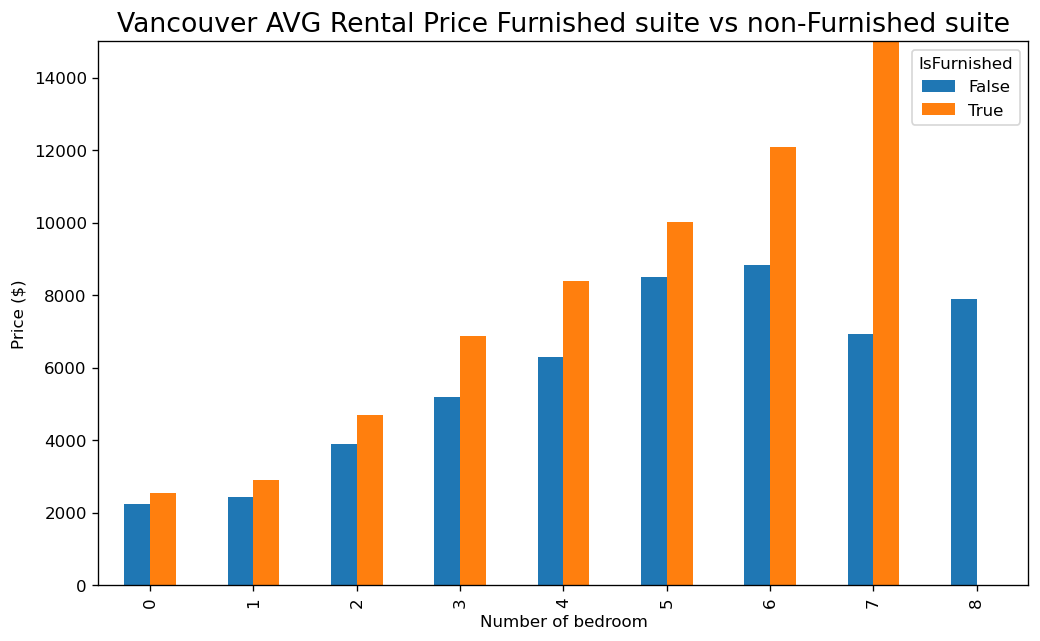

In [55]:
df_price_furnished["Price"]["mean"].unstack().plot(kind='bar')
plt.title(f'{city} AVG Rental Price Furnished suite vs non-Furnished suite', fontsize=16)
plt.xlabel('Number of bedroom')
plt.ylabel('Price ($)')
plt.ylim((0, 15000));

In [56]:
titles = []
for title in df["Post Title"][:5]:
    titles.append(title)
titles

['STUNNING Furnished 2 BEDROOM + Loft Townhouse in Kits',
 'STUNNING Furnished 4 Bed House in Kerrisdale Available Now',
 'Large 1 BR Suite; Sunset Beach (Vancouver)',
 'Fully Renovated 2BR suite@Parkview Tower w/872 SF Patio & View-Jan 1st',
 '3BR+Flex @ 8x on the Park in Yaletown - 23rd FL w/View - Avail Now']

In [57]:
df[['Post Datetime', 'Post Title', "Price", "Bedroom", "IsFurnished"]][:10]

,Post Datetime,Post Title,Price,Bedroom,IsFurnished
0,2022-12-28 11:05:00,STUNNING Furnished 2 BEDROOM + Loft Townhouse ...,8995,2,True
1,2022-12-28 11:05:00,STUNNING Furnished 4 Bed House in Kerrisdale A...,9695,4,True
2,2022-12-28 11:04:00,Large 1 BR Suite; Sunset Beach (Vancouver),2522,1,False
3,2022-12-28 11:02:00,Fully Renovated 2BR suite@Parkview Tower w/872...,6200,2,False
4,2022-12-28 11:02:00,3BR+Flex @ 8x on the Park in Yaletown - 23rd F...,5995,3,False
5,2022-12-28 11:02:00,Beautifully Furnished 2 BR condo w/City View i...,3900,2,True
6,2022-12-28 11:01:00,Townhouse For Rent,2700,2,False
7,2022-12-28 11:00:00,Kits 1br Big beautiful suite ground floor with...,2200,1,False
8,2022-12-28 10:59:00,Magnificent 2bed/bath at Viceroy available Jan 1,3200,2,False
9,2022-12-28 10:57:00,Cambie Gardens - BRAND NEW - 1bed 1bath,2550,1,False


In [58]:
np.mean(df["Price/SQFT"])

4.74928185746485

## Act